# Three ways of conducting single-SNP GWAS

There are many ways to conducting single-SNP GWAS. Three methods are introduced in this notebook, including rrBLUP (Endelman, 2011), EEMAX (Kang et al. ,2010) and GCTA (Yang et al., 2011). The Rice Diversity Panel with 413 Oryza sativa individual accessions is used to demonstrate the three methods, and the trait of flowering time in Arkansas was considered in GWAS. After removing the records with missing data for the traitand genotypes with minor allele frequency less than 0.05, 374 individuals and 33701 SNPs are included in the analysis. The data are publicly available on http://www.ricediversity.org/.

In [1]:
Genotype = read.csv('/Users/lijinghui/Desktop/Server_result/Real_data_error/genotype_y2.csv')
Map = read.csv('/Users/lijinghui/Desktop/Server_result/Real_data_error/controlled_map.csv')
Phenotype = read.csv('/Users/lijinghui/Desktop/Server_result/Real_data_error/phenotype_y2.csv')

In [2]:
head(Phenotype)

NSFTVID,y2
1,75.08333
3,89.50000
4,94.50000
5,87.50000
6,89.08333
7,105.00000


In [12]:
head(Map)

marker,chrom,pos
id1000001,1,13147
id1000003,1,73192
id1000005,1,74969
id1000007,1,75852
id1000008,1,75953
id1000011,1,91016


In [13]:
head(Genotype[, 1:10])

X,id1000001,id1000003,id1000005,id1000007,id1000008,id1000011,id1000013,id1000015,id1000016
1,0,0,0,0,0,0.0000000,0,0,0
2,2,2,0,2,2,0.1965318,0,2,2
3,2,2,0,2,2,2.0000000,0,2,2
4,2,2,2,0,2,0.0000000,2,2,2
5,2,2,0,2,2,2.0000000,0,2,2
6,0,0,0,0,0,0.0000000,0,0,0


For simplicity of the description, all analyses in this notebook are based on a single-trait regression model with a general mean as the only fixed effect. The model for individual i from n genotyped individuals can be written as
$$y_i = \mu + \sum_{j=1}^p m_{ij} \alpha_j + e_i $$
where $y_i$ is the phenotype value for individual $i$, $\mu$ is the overall mean, $m_{ij}$ is the genotype covariate at locus $j$ for individual $i$ (coded as 0, 1 and 2), $\alpha_j$ is the marker effect for locus $j$, and $e_i$ is the random residual for individual $i$.

## rrBLUP

GWAS function in rrBLUP (Endelman, 2011) performs genome-wide association analysis based on linear mixed models. Details of the package description can be found on https://cran.r-project.org/web/packages/rrBLUP/rrBLUP.pdf.

In [8]:
library(rrBLUP)
y = Phenotype$y2
Z = as.matrix(Genotype[,-1])
geno = data.frame(marker=1:nrow(Map), chrom=Map$chrom, pos=Map$pos, t(Z), check.names = F)
GWAS_rrBLUP = GWAS(pheno = data.frame(line=1:length(y), y=y), geno = geno, min.MAF = 0)

[1] "GWAS for trait: y"
[1] "Variance components estimated. Testing markers."


Function arguments:

pheno: A data frame where the first column is the line name. The remaining columns can be either a phenotype or the levels of a fixed effect. Any column not designated as a fixed effect is assumed to be a phenotype.

geno: A data frame with the marker names in the first column. The second and third columns contain the chromosome and map position (either bp or cM), respec- tively, which are used only when plot=TRUE to make Manhattan plots. If the markers are unmapped, just use a placeholder for those two columns. Columns 4 and higher contain the marker scores for each line, coded as {-1,0,1} = {aa,Aa,AA}. Fractional (imputed) and missing (NA) values are allowed. The column names must match the line names in the "pheno" data frame.

min.MAF: Specifies the minimum minor allele frequency (MAF). If a marker has a MAF less than min.MAF, it is assigned a zero score.

In [9]:
head(GWAS_rrBLUP)

,marker,chrom,pos,y
id1000001,1,1,13147,1.5227432
id1000003,2,1,73192,1.4543089
id1000005,3,1,74969,0.1339347
id1000007,4,1,75852,1.0918423
id1000008,5,1,75953,1.6246671
id1000011,6,1,91016,0.7044660


The function returns a data frame where the first three columns are the marker name, chromosome, and position, and subsequent columns are the marker scores (−log p) for the traits. Note that whether including an intercept or not does not affect the GWAS result in this case. 

In [11]:
GWAS_rrBLUP2 = GWAS(pheno = data.frame(line=1:length(y), y=y, incept = rep(1, length(y))), geno = geno, min.MAF = 0)
head(GWAS_rrBLUP2)

,marker,chrom,pos,y,incept
id1000001,1,1,13147,1.5227432,14.633533
id1000003,2,1,73192,1.4543089,54.976494
id1000005,3,1,74969,0.1339347,34.993461
id1000007,4,1,75852,1.0918423,4.064271
id1000008,5,1,75953,1.6246671,22.631191
id1000011,6,1,91016,0.7044660,24.529240


## EEMAX

The EEMAX procedure was developed by Kang et al. (2010) to conduct single-SNP GWAS, and was expanded to GWAS based genomic windows by Chen et al. (2017). The code below demonstrates the single-SNP GWAS using EEMAX, and can easily be adapted to conduct GWAS based on genomic windows using window size 100 SNP, 0.1 Mb or 1 Mb. 

In [14]:
## Map data organization, can be used for single SNP, window size of 100 SNP, 0.1 Mb and 1 Mb
window_dat_org = function (window_size){
  win = c()
  winrow = c()
  if (window_size == 100 | window_size == 1) {
    Map$num = 0:(nrow(Map) - 1)
    class = table(floor(Map$num / window_size))
    clapos = 1
    for (n in 1:length(class)) {
      win = append(win, c(Map$pos[clapos], Map$pos[clapos + class[n] - 1]))
      clapos = clapos + class[n]
    }
    winrow = append(winrow, class)
  } else {
    for (i in 1:12) {
      Map_sub = Map[Map$chrom == i,]
      class = table(floor(Map_sub$pos / window_size))
      clapos = 1
      for (n in 1:length(class)) {
        win = append(win, c(Map_sub$pos[clapos], Map_sub$pos[clapos + class[n] - 1]))
        clapos = clapos + class[n]
      }
      winrow = append(winrow, class)
    }
  }
  
  chrom = c()
  ch = 1
  if (window_size == 100) {
    for (i in 1:(length(winrow) - 1)) {
      if (win[2*i - 1] < win[2*i]){
        chrom[i] = ch
      } else {
        chrom[i] = ch
        ch = ch + 1
      }
    }
    chrom[length(chrom) + 1] = 12
  } else if (window_size == 1) {
    chrom = Map$chrom
  } else {
    for (i in 1:(length(winrow) - 1)) {
      if (floor(abs(win[2*i + 1] - win[2*i])/window_size) < 10){
        chrom[i] = ch
      } else {
        chrom[i] = ch
        ch = ch + 1
      }
    }
    chrom[length(chrom) + 1] = 12
  }
  
  window_dat = data.frame(chr = chrom, start_SNP = win[2 * (1:length(winrow)) - 1],
                          end_SNP = win[2 * (1:length(winrow))], window = 1:length(winrow), 
                          numSNP = winrow)
  
  return(window_dat)
}

In [15]:
## Calculate genetic effect vector g and genetic variance sigmag2 using mixed.solve function in rrBLUP package
y = Phenotype$y2
Z = as.matrix(Genotype[,-1])
result = mixed.solve(y = y, Z = Z)
g = result$u
sigmag2 = result$Vu

In [ ]:
## Calculate the random-by-random portion of the inverse coefficient matrix described by Chen et al. (2017)
X = rep(1, nrow(Phenotype))
A = t(X) %*% X / sigmae2
B = t(X) %*% Z / sigmae2
C = t(Z) %*% X / sigmae2
D = t(Z) %*% Z / sigmae2 + diag(ncol(Z)) / sigmag2
Cgg = solve(D - C %*% solve(A) %*% B)

Note that the calculation of Cgg requires large amount of computer memory, therefore direct calculation on personal computer is not recommended. The Cgg matrix here is calculated in advance and read directly.

In [16]:
Cgg = readRDS('/Users/lijinghui/Desktop/Server_result/Real_data_error/Fre_minP_result/Cgg_matrix')

In [17]:
## Calculate chi square value of each SNP (or window)
chi2_cal = function (win_dat, Cgg, g, sigmag2) {
  chi2k = c()
  i = 1
  winpos = 1
  winrow = win_dat$numSNP
  for (k in 1:length(winrow)) {
    gk = g[winpos : (winpos + winrow[k] - 1)]
    Cggk = Cgg[winpos : (winpos + winrow[k] - 1), winpos : (winpos + winrow[k] - 1)]
    winpos = winpos + winrow[k]
    if (length(Cggk) == 1) {
      a = 1
    } else {a = ncol(Cggk)}
    chi2k[i] = t(gk) %*% solve(diag(a) * sigmag2 - Cggk) %*% gk
    i = i + 1
  }
  return(list(chi2k = chi2k, df = winrow))
}

In [18]:
win_1 = window_dat_org(1)
chi2k_1 = chi2_cal(win_1, Cgg, g, sigmag2)
neg_log_P = -pchisq(chi2k_1[[1]], chi2k_1[[2]], lower.tail = F, log.p = T) # Negative log P value of each SNP

In [19]:
win_1$neg_log_P = neg_log_P

In [20]:
head(win_1)

,chr,start_SNP,end_SNP,window,numSNP,neg_log_P
0,1,13147,13147,1,1,3.8350819
1,1,73192,73192,2,1,3.7199774
2,1,74969,74969,3,1,0.4225279
3,1,75852,75852,4,1,2.6657228
4,1,75953,75953,5,1,4.1851383
5,1,91016,91016,6,1,1.7026097


## GCTA

The previous two methods are implemented in R, while GCTA is developed for the three major operating systems: MS Windows, Linux/ Unix, and Mac OS. Here is the basic code:

./gcta64 --mlma --bfile geno_and_map --grm geno_and_map --pheno phenotype --out gcta_result --thread-num 10

where geno_and_map contains genotypic and map information, phenotype contains phenotypic information. More details about the software is available on https://cnsgenomics.com/software/gcta/.

For simplicity, the result is converted to csv file and shown below.

In [41]:
GCTA_result = read.csv('/Users/lijinghui/Desktop/Server_result/Real_data_error/GCTA/GCTA_result.csv')

In [42]:
head(GCTA_result)

Chr,SNP,bp,A1,A2,Freq,b,se,p
1,id1000001,13147,C,T,0.3002680,-2.761830,1.20036,0.0214013
1,id1000003,73192,C,T,0.3029490,-2.740320,1.20677,0.0231599
1,id1000005,74969,T,C,0.1608580,-0.963735,1.90087,0.6121560
1,id1000007,75852,A,G,0.1336900,-2.173230,1.19018,0.0678558
1,id1000008,75953,G,T,0.2983870,-2.915690,1.20329,0.0153886
1,id1000011,91016,G,A,0.0923567,-1.739430,1.31994,0.1875680


In [52]:
GCTA_result$neg_log_P = -log(GCTA_result$p)  # convert p value to -log(p)

## Manhattan plots of three methods

In [44]:
library(qqman)  # use manhattan function in qqman

In [45]:
manhattan_rrblup = data.frame(BP = GWAS_rrBLUP$pos, CHR = GWAS_rrBLUP$chrom, P = GWAS_rrBLUP$y, 
                              SNP = GWAS_rrBLUP$marker)

In [46]:
manhattan_EEMAX = data.frame(BP = win_1$start_SNP, CHR = win_1$chr, P = win_1$neg_log_P, SNP = win_1$window)

In [53]:
manhattan_GCTA = data.frame(BP = GCTA_result$bp, CHR = GCTA_result$Chr, P = GCTA_result$neg_log_P, 
                            SNP = GCTA_result$SNP)

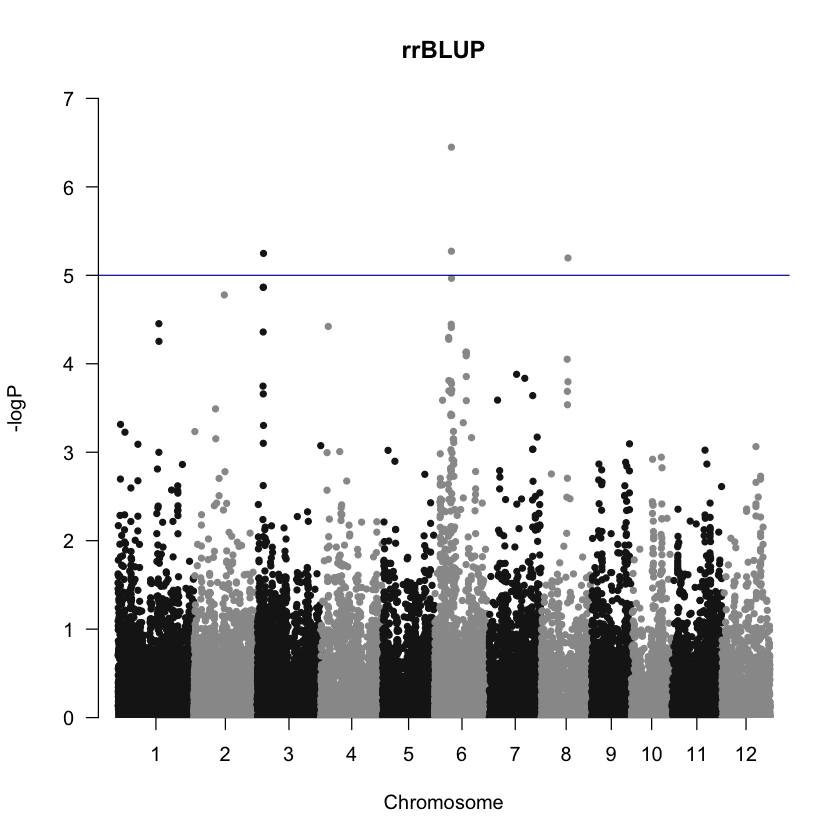

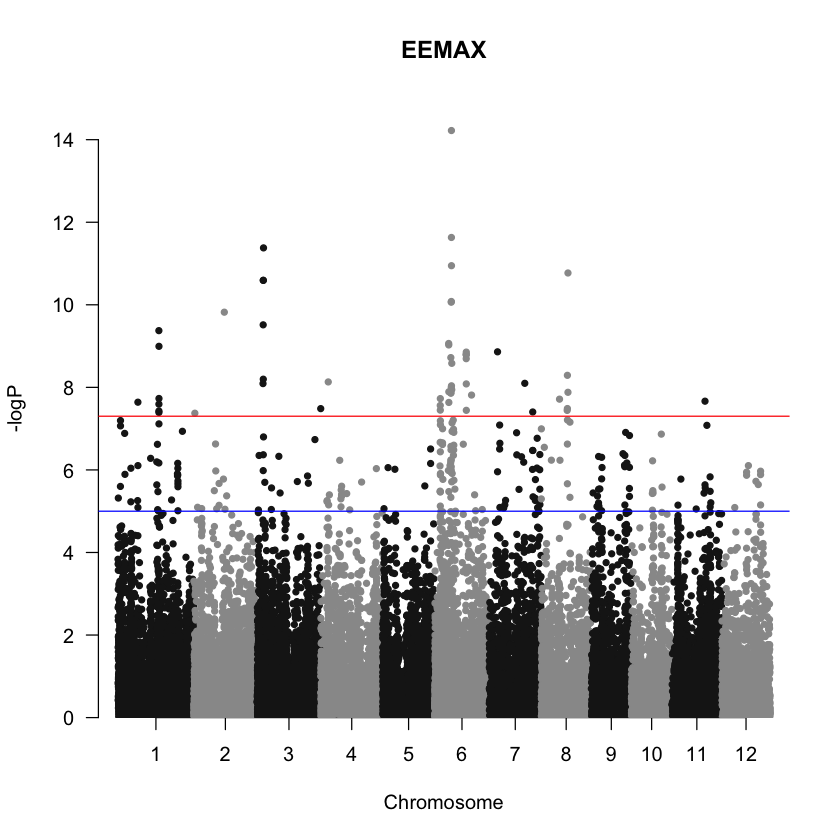

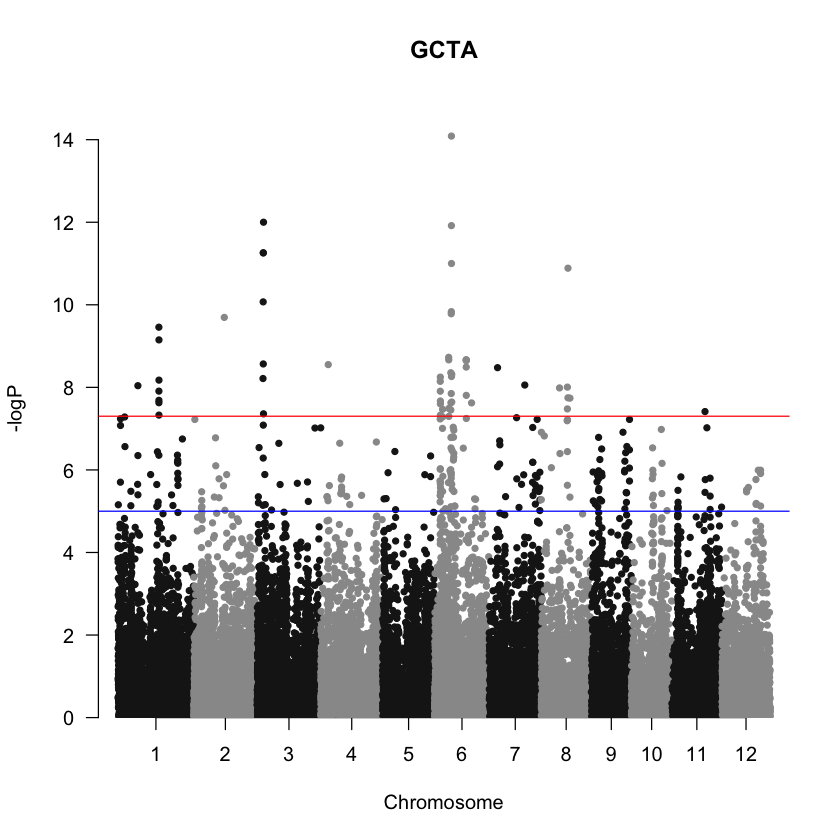

In [64]:
manhattan(manhattan_rrblup, logp = F, ylab = '-logP', main = 'rrBLUP')
manhattan(manhattan_EEMAX, logp = F, ylab = '-logP', main = 'EEMAX')
manhattan(manhattan_GCTA, logp = F, ylab = '-logP', main = 'GCTA')

The manhattan plots show that three methods have very close results. Although the p values in rrBLUP are different from the other two in scale, three methods share similar relative magnitude of p values, thus does not prevent people from finding significant SNPs.